# Compute how much female motion can be explained by conditioning on preceding song sequence

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys
import warnings; warnings.filterwarnings("ignore")

from disp import set_plot

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)

In [2]:
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')
df_song

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_song.ID) + 1
dfs_tr = [df_song[df_song.ID == i] for i in ISTRAIN]

df_song = None

In [4]:
# loop through trials and add MTN vars to dataset
dfs_clean = []
for itr, df_tr in zip(ISTRAIN, dfs_tr):
    sys.stdout.write('.')
    # load extended behavior data for this trial
    df_xtd_tr = pd.read_csv(f'{PFX_BHV_XTD}_tr_{itr}.csv')
    assert len(df_tr) == len(df_xtd_tr)
    
    # add targ behav to trial data frame
    for targ in TARGS:
        df_tr[targ] = np.array(df_xtd_tr[targ])[np.random.permutation(len(df_tr))]
        
    # add song column
    song = np.zeros(len(df_tr), dtype=int)
    song[df_tr['S'] == 1] = 1
    song[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    
    df_tr['SONG'] = song
    
    df_clean = df_tr[['ID', 'FRAME', 'T', 'SONG'] + TARGS]
    dfs_clean.append(df_clean)
    
dfs_tr = None

.......................................................................................

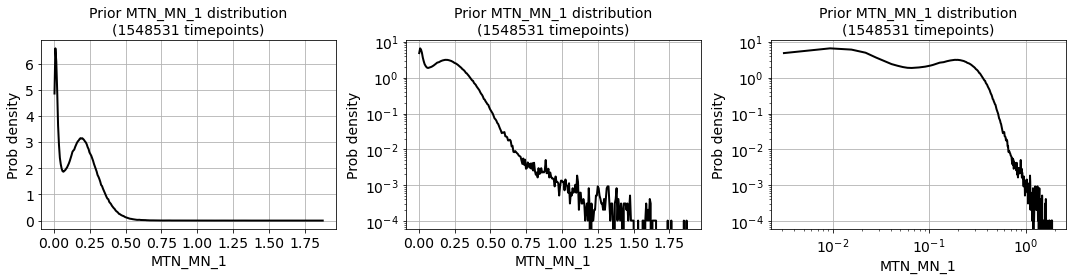

In [5]:
# compute prior over target vars
TARG = 'MTN_MN_1'
BINS = np.linspace(0, 1.88, 301)
BINC = .5*(BINS[:-1] + BINS[1:])

mtn_prior = cc([np.array(df_tr[TARG]) for df_tr in dfs_clean])
nmtn = len(mtn_prior)
frac = np.histogram(mtn_prior, bins=BINS, density=True)[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
axs[0].plot(BINC, frac, lw=2, c='k')
axs[1].semilogy(BINC, frac, lw=2, c='k')
axs[2].loglog(BINC, frac, lw=2, c='k')
for ax in axs:
    ax.grid()
    set_plot(ax, x_label=TARG, y_label='Prob density', title=f'Prior {TARG} distribution\n({nmtn} timepoints)', font_size=14)

## Info-theoretic calculations

In [8]:
# compute MTN distributions conditional on preceding song snippet
NBAKS = np.array([1, 2, 3, 4, 5, 6])  # number of timesteps to look back
# NBAK_PLOT = [2, 5]
PLOT = False

mtn_song_info = np.nan*np.zeros(len(NBAKS))

In [9]:
for cnbak, NBAK in enumerate(NBAKS):
    sys.stdout.write('.')
    snippets = list(cproduct((0, 1, 2), repeat=NBAK))  # all possible song snippets
    snippet_cts = np.zeros(len(snippets))  # for storing snippet counts
    mtn_cond = {snippet: [] for snippet in snippets}  # motion variables conditioned on preceding song snippet

    for df_tr in dfs_clean:
        song = np.array(df_tr['SONG'], dtype=int)

        # create extended song array
        song_xtd = -1*np.ones((len(song), NBAK), dtype=int)
        song_xtd[:, -1] = song
        for ctbak in range(1, NBAK):
            song_xtd[ctbak:, -1-ctbak] = song[:-ctbak]

        # loop over snippets
        for csnippet, snippet in enumerate(snippets):
            imatch = (song_xtd == snippet).all(axis=1)
            mtn_cond[snippet].extend(np.array(df_tr[TARG][imatch]))
            snippet_cts[csnippet] += imatch.sum()
            
    str_snippets = [''.join([str(i) for i in snippet]) for snippet in snippets]

    # prior
    frac = np.histogram(mtn_prior, bins=BINS, density=True)[0]
    pmtn_prior = frac/frac.sum()

    if PLOT:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
        axs[0].plot(BINC, frac, lw=2, c='k')
        axs[1].semilogy(BINC, frac, lw=2, c='k')
        axs[2].loglog(BINC, frac, lw=2, c='k')
        for ax in axs:
            ax.grid()
            set_plot(ax, x_label=TARG, y_label='Prob density', title=f'Prior {TARG} distribution\n({nmtn} timepoints)', font_size=14)

    # silent and pure song
    if PLOT:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
        for mode, color in zip((0, 1, 2), ('gray', 'b', 'r')):
            snippet = NBAK*(mode,)
            frac = np.histogram(mtn_cond[snippet], bins=BINS, density=True)[0]

            axs[0].plot(BINC, frac, lw=2, c=color)
            axs[1].semilogy(BINC, frac, lw=2, c=color)
            axs[2].loglog(BINC, frac, lw=2, c=color)
            for ax in axs:
                ax.grid()
                set_plot(ax, x_label=TARG, y_label='Prob density', title=f'{NBAK}-step pure-mode conditional\n{TARG}distribution', font_size=14)

    # all conditionals
    pmtn_cond = {}
    if PLOT:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

    for snippet in snippets:
        frac = np.histogram(mtn_cond[snippet], bins=BINS, density=True)[0]
        pmtn_cond[snippet] = frac/frac.sum()

        if PLOT:
            axs[0].plot(BINC, frac, lw=1, c='gray')
            axs[1].semilogy(BINC, frac, lw=1, c='gray')
            axs[2].loglog(BINC, frac, lw=1, c='gray')
            for ax in axs:
                ax.grid()
                set_plot(ax, x_label=TARG, y_label='Prob density', title=f'{NBAK}-step song conditional\n{TARG}distributions', font_size=14)

    if PLOT:
        fig, ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)
        ax.bar(np.arange(3**NBAK), snippet_cts)
        ax.set_xticks(np.arange(3**NBAK))
        ax.set_xticklabels(str_snippets, rotation=90)
        set_plot(ax, y_label='# timepoints', title='Song snippet distributions')

    # compute info quantities
    psnippet = snippet_cts/np.sum(snippet_cts)

    hmtn_prior = stats.entropy(pmtn_prior, base=2)
    hmtn_cond = np.array([stats.entropy(pmtn_cond[snippet], base=2) for snippet in snippets])
    hmtn_cond[psnippet == 0] = 0
    avg_hmtn_cond = hmtn_cond @ psnippet
    
    mtn_song_info[cnbak] = hmtn_prior - avg_hmtn_cond

......

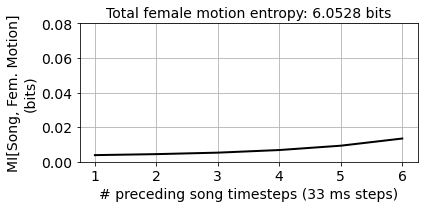

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(NBAKS, mtn_song_info, lw=2, c='k')
ax.grid()
ax.set_ylim(0, 0.08)
set_plot(ax, x_label='# preceding song timesteps (33 ms steps)', y_label='MI[Song, Fem. Motion]\n(bits)', title=f'Total female motion entropy: {hmtn_prior:.4f} bits', font_size=14)